<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Сэмплирование-данных" data-toc-modified-id="Сэмплирование-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Сэмплирование данных</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Модель-Google-Bert" data-toc-modified-id="Модель-Google-Bert-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Модель Google-Bert</a></span></li><li><span><a href="#Формирование-признаков" data-toc-modified-id="Формирование-признаков-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Формирование признаков</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Baseline-метрика" data-toc-modified-id="Baseline-метрика-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Baseline-метрика</a></span></li><li><span><a href="#Качество-модели-на-тестовой-выборке" data-toc-modified-id="Качество-модели-на-тестовой-выборке-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Качество модели на тестовой выборке</a></span></li><li><span><a href="#Анализ-модели" data-toc-modified-id="Анализ-модели-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Анализ модели</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп» с BERT

Согласно проектному заданию, интернет-магазин «Викишоп» запускает новый сервис. Пользователи смогут редактировать и дополнять описания товаров, как в вики-сообществах.   
Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучить модель, которая будет классифицировать комментарии на позитивные и негативные. Заказчиком предоставлен набор данных с разметкой о токсичности правок.

Таргетное значение метрики качества *F1* - не меньше 0.75. 

Для выполнения проекта используется предобученная английская базовая модель *BERT*, без учета регистра.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [1]:
#Обновим критические библиотеки
!pip install -U scipy
!pip install numpy==1.26.4
!pip install -U numba
!pip install -U scikit-learn
!pip install -U matplotlib
!pip install -U seaborn
!pip install -U optuna
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install transformers
!pip install imblearn
!pip install -U shap

Looking in indexes: https://download.pytorch.org/whl/cu118


In [2]:
import pandas as pd
import torch
import transformers
import numpy as np
import seaborn as sns
import time

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import shap

import optuna
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import notebook
from imblearn.under_sampling import RandomUnderSampler

In [3]:
#Установим общие правила
pd.set_option('display.max_columns', 35)
sns.set_theme(rc={"figure.dpi": 96})

In [4]:
#Установим глобальные переменные
RANDOM_STATE = 42
TEST_SIZE = 0.2

## Подготовка

### Загрузка данных

Произведём загрузку и первичный анализ предоставленных данных.

In [5]:
try:
    data_toxic = pd.read_csv('/datasets/toxic_comments.csv', index_col=[0])
except:
    data_toxic = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv', index_col=[0])

data_toxic.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [6]:
print('Дубликатов в данных:',data_toxic.duplicated().sum())

data_toxic.info()

Дубликатов в данных: 0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


Типы данных в целом соответствуют ожидаемым, пропусков, дубликатов и аномалий - не обнаружено.  
Рассмотрим распределение данных по целевому признаку.

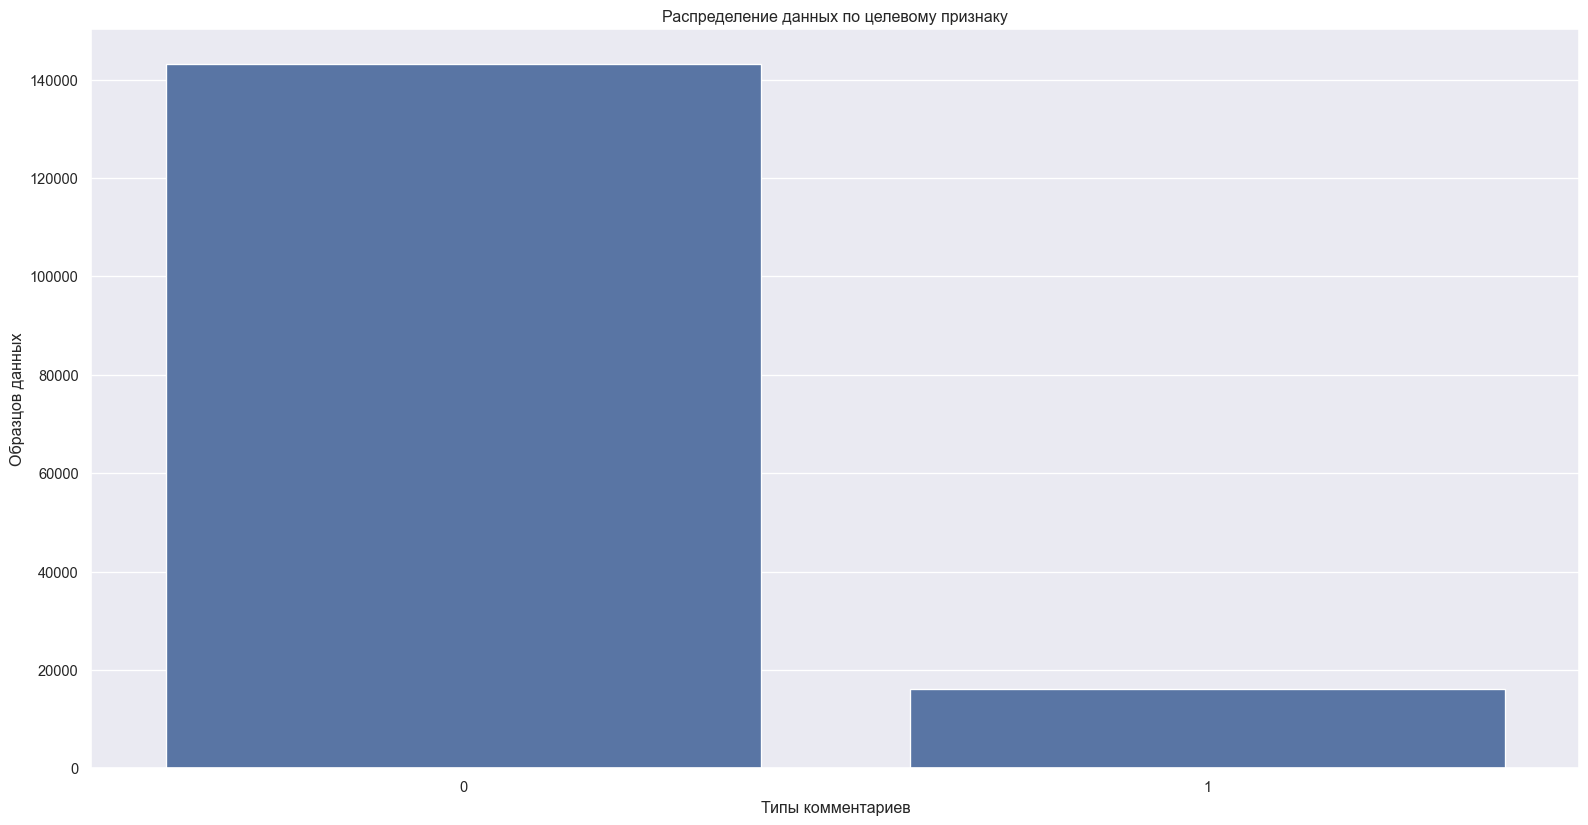

In [7]:
fig, ax = plt.subplots(figsize =(20, 10))
sns.barplot(x=data_toxic['toxic'].unique(), y=data_toxic.groupby('toxic')['text'].count(), ax = ax);
ax.set_xlabel('Типы комментариев')
ax.set_ylabel('Образцов данных')
ax.set_title('Распределение данных по целевому признаку');
plt.show()

В данных наблюдается значительный дисбаланс классов.  
Выполним андерсемплирование данных - это дополнительно сократит вычислительную нагрузку на модель.

 <div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Данные загружены корреткно. Молодец, что проверяешь баланс классов)

### Сэмплирование данных

Исходя из возможностей вычислительного оборудования, снизим количество образцов данных до 4000.

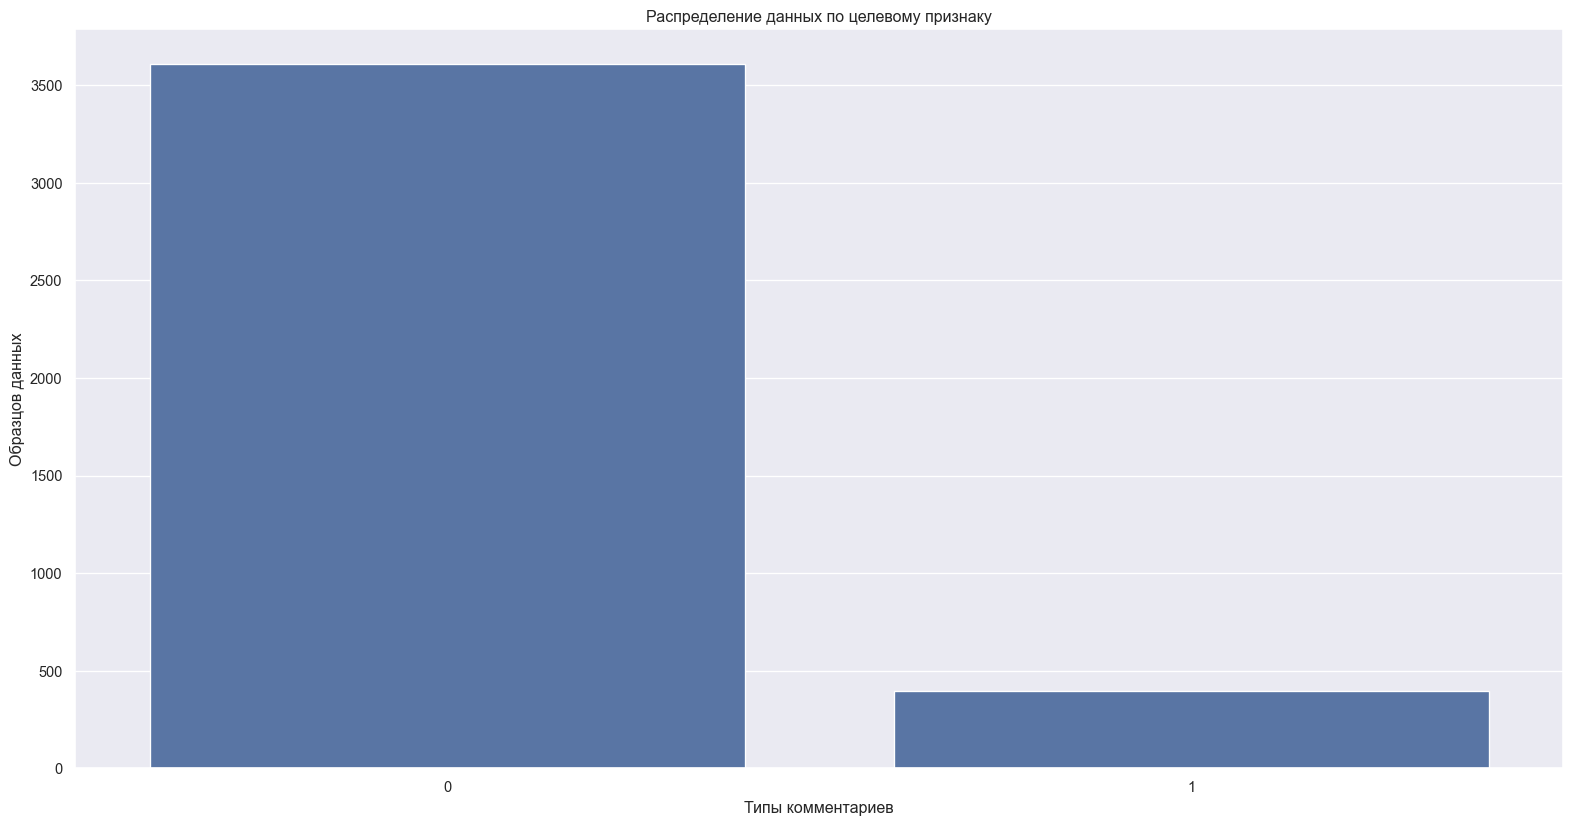

In [8]:
X_resample = data_toxic.sample(n = 4000, random_state=RANDOM_STATE)

fig, ax = plt.subplots(figsize =(20, 10))
sns.barplot(x=X_resample['toxic'].unique(), y=X_resample.groupby('toxic')['text'].count(), ax = ax);
ax.set_xlabel('Типы комментариев')
ax.set_ylabel('Образцов данных')
ax.set_title('Распределение данных по целевому признаку');
plt.show();

## Обучение

### Модель Google-Bert

Загрузим обученную модель и токенизатор, при помощи средств библиотеки Transformer из репозитория Hugging Face.

In [9]:
tokenizer = AutoTokenizer.from_pretrained("unitary/toxic-bert")
model = AutoModelForSequenceClassification.from_pretrained("unitary/toxic-bert")

### Формирование признаков

Выполним токенизацию, добор до необходимых длин и преобразование маски внимания.

In [10]:
tokenized = X_resample['text'].apply(
    lambda x: tokenizer.encode(x, max_length= 512,truncation=True, add_special_tokens=True))

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

Выполним подготовку признаков - преобразуем текст в эмбеддинги.

In [26]:
batch_size = 64
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0].numpy())

  0%|          | 0/62 [00:00<?, ?it/s]

Подготовим матрицу признаков.

In [48]:
features = np.concatenate(embeddings)
data_concat = pd.concat([X_resample.reset_index(drop=True), pd.DataFrame(features)], axis=1)
data_concat = data_concat.dropna()
data_concat.head()

,text,toxic,0
0,"Sometime back, I just happened to log on to ww...",0,-7.152328
1,"""\n\nThe latest edit is much better, don't mak...",0,-7.264576
2,""" October 2007 (UTC)\n\nI would think you'd be...",0,-7.393531
3,Thanks for the tip on the currency translation...,0,-7.428422
4,I would argue that if content on the Con in co...,0,-7.452366


### Обучение моделей

Разделим данные на тренировочную и тестовую выборки.

In [49]:
X_train, X_test, y_train, y_test = train_test_split(
    data_concat.drop(['toxic', 'text'], axis=1),
    data_concat['toxic'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    )

Подбор параметров моделей будет выполняться при помощи библиотеки Optuna.  
Для побора модели модели создаётся инстанс optuna.study, который оптимизирует результат функции в нужную сторону (максимизирует в нашем случае).  
Функция модели включает в себя: параметры для подбора и оптимизации, модель машинного обучения, кросс-валидацию предсказаний и расчёт метрики.  
Вывод функции - значение метрики, которое и максимизируется средствами библиотеки.

In [50]:
#задаём функцию для последующей оптимизации модели 
def objective(trial):
    #задаём параметры функции через метод suggest - оптуна перебирает предложенные ей параметры
    classifier_name = trial.suggest_categorical("classifier", ["Logreg", "Randforest"])
    if classifier_name == "Logreg":
    #в завимимости от выбранной модели передаём прочие параметры
        lgr_penalty = trial.suggest_categorical("penalty", ["l1", "l2"])
        lgr_C = trial.suggest_int("C", 1, 30, log=True)
        classifier_obj = LogisticRegression(
            penalty = lgr_penalty,
            C = lgr_C,
            solver = 'liblinear',
            random_state=RANDOM_STATE
            )
        
    else:
        rf_max_depth = trial.suggest_int("rf_max_depth", 2, 32, log=True)
        rf_min_split= trial.suggest_int("rf_min_split", 2, 5, log=True)
        classifier_obj = RandomForestClassifier(
            max_depth=rf_max_depth,
            min_samples_split = rf_min_split,
            random_state=RANDOM_STATE
            )
    
    #Обучаем модель
    start = time.time()
    ml_opt = classifier_obj.fit(X_train, y_train)
    ml_time = time.time() - start
    #Задаём дополнительный пользовательский параметр для сохранения модели - в дальнейшем его вызывает функция коллбэка 
    trial.set_user_attr(key="best_model", value=ml_opt)
    trial.set_user_attr(key="best_model_time", value=ml_time)
    #Делаем предсказания, считаем метрику 
    cross_lgb = cross_val_score(classifier_obj, X_train, y_train, cv=3, scoring='f1') 
    F1 = cross_lgb.mean()

    #Возвращаем метрику которую будет оптимизировать оптуна
    return F1

In [51]:
#функция коллбэка - чтобы можно было работать напрямую с лучшей модель
def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_model", value=trial.user_attrs["best_model"])
        study.set_user_attr(key="best_model_time", value=trial.user_attrs["best_model_time"])

In [52]:
# зададим параметры study, лучшая модель сохраняется как результат функции коллбэка
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler = sampler)
study.optimize(objective, n_trials=35, callbacks=[callback])
best_model=study.user_attrs["best_model"]
best_model_time=study.user_attrs["best_model_time"]
print(study.best_trial)
print()
print('Модель с лучшими гиперапараметрами:',best_model)
print('Время обучения лучшей модели:',best_model_time)

[I 2024-07-24 10:43:47,967] A new study created in memory with name: no-name-e9d81298-59ab-4879-afee-da8db234489b
[I 2024-07-24 10:43:48,670] Trial 0 finished with value: 0.924346230208477 and parameters: {'classifier': 'Randforest', 'rf_max_depth': 14, 'rf_min_split': 3}. Best is trial 0 with value: 0.924346230208477.
[I 2024-07-24 10:43:48,703] Trial 1 finished with value: 0.9419281718105301 and parameters: {'classifier': 'Logreg', 'penalty': 'l2', 'C': 6}. Best is trial 1 with value: 0.9419281718105301.
[I 2024-07-24 10:43:48,727] Trial 2 finished with value: 0.9400751205727639 and parameters: {'classifier': 'Logreg', 'penalty': 'l1', 'C': 1}. Best is trial 1 with value: 0.9419281718105301.
[I 2024-07-24 10:43:49,423] Trial 3 finished with value: 0.9398997927096598 and parameters: {'classifier': 'Randforest', 'rf_max_depth': 4, 'rf_min_split': 3}. Best is trial 1 with value: 0.9419281718105301.
[I 2024-07-24 10:43:49,449] Trial 4 finished with value: 0.9400751205727639 and parameter

FrozenTrial(number=27, state=TrialState.COMPLETE, values=[0.944766609392898], datetime_start=datetime.datetime(2024, 7, 24, 10, 44, 2, 705856), datetime_complete=datetime.datetime(2024, 7, 24, 10, 44, 3, 388054), params={'classifier': 'Randforest', 'rf_max_depth': 4, 'rf_min_split': 5}, user_attrs={'best_model': RandomForestClassifier(max_depth=4, min_samples_split=5, random_state=42), 'best_model_time': 0.1865248680114746}, system_attrs={}, intermediate_values={}, distributions={'classifier': CategoricalDistribution(choices=('Logreg', 'Randforest')), 'rf_max_depth': IntDistribution(high=32, log=True, low=2, step=1), 'rf_min_split': IntDistribution(high=5, log=True, low=2, step=1)}, trial_id=27, value=None)

Модель с лучшими гиперапараметрами: RandomForestClassifier(max_depth=4, min_samples_split=5, random_state=42)
Время обучения лучшей модели: 0.1865248680114746


### Baseline-метрика

Получим baseline - значение метрики, для последующего определения качества модели.

In [53]:
dummy_class = DummyClassifier(strategy='stratified', random_state=RANDOM_STATE)
dummy_class.fit(X_train, y_train)


print(
    'Метрика baseline: ',
    f1_score(y_test, dummy_class.predict(X_test))
)

Метрика baseline:  0.10650887573964497


### Качество модели на тестовой выборке

Рассмотрим качество модели на тестовой выборке.

In [54]:
y_pred = best_model.predict(X_test)

print('Метрика модели на тестовой выборке:', f1_score(y_test, y_pred))

Метрика модели на тестовой выборке: 0.9578947368421052


Полученное значение - выше таргета в 0,75.  

### Анализ модели

Проведём shap-анализ работы модели - хотя он не покажет влияния отдельных слов, но поможет выявить переобучение модели, либо утечку данных.

In [55]:
explainer = shap.Explainer(model = best_model.estimator.fit(X_train, y_train))
shap_values = explainer(X_test)

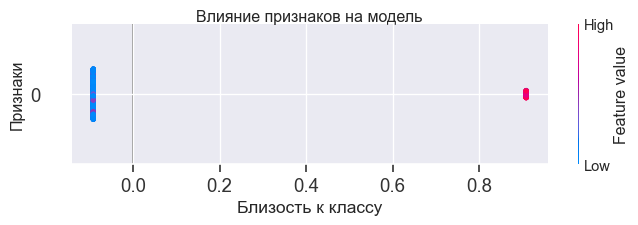

In [56]:
fig, (ax1) = plt.subplots(1, 1)

plt.sca(ax1)
shap.plots.beeswarm(shap_values[:,:,1], show=False)
plt.subplots_adjust(hspace=0.5)
ax1.tick_params(labelsize=14)
ax1.set_xlabel('Близость к классу', va='top')
ax1.set_title('Влияние признаков на модель', va='top')
ax1.set_ylabel('Признаки');
plt.show();

Модель прямо интерпретирует значения токсичности полученные из Toxic-Bert.  
Это не является проблемой, пока определение токсичных комментариев внутри компании совпадает с представлениями о токсичности использовавшимися на обучении языковой модели.  
При расходениях в этих определениях может потребоваться дообучение модели.

## Выводы

По выполнению проекта можно сделать следующие выводы:  
  
1) Предоставленные данные не содержат аномалий и пропусков. Проведённый анализ показывает значительный дисбаланс классов в предоставленных данных, нивелированный семплированием перед обучением модели.
 

2) По результатам моделирования, лучшая модель - модель случайного леса (RandomForestClassifier). Метрика модели на тестовой выборке: 0.95. Метрика baseline: 0.11.  
  
3) Для обучения модели был использован небольшой набор данных (около 20%) предоставленного датасета. При наличии больших вычислительных мощностей, возможно увеличение качества модели.  